We will implement cycle GAN to change styles of painting

### Import Libraries

In [45]:
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

### Initial Setting

In [46]:
n_cpu = 2 # number of cpu threads to use during batch generation

In [47]:
# data (path)
dataset_name = 'gan-getting-started'
root = '../input/'+dataset_name

# data (img)
img_height = 256
img_width = 256
channels = 3

# training
epoch = 0 
n_epochs = 30
batch_size = 1 
decay_epoch = 15


###  Define Generator

In [48]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Pads the input tensor using the reflection of the input boundary
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features), 
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_block):
        super(GeneratorResNet, self).__init__()
        channels = input_shape[0]
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True)
        ]
        in_features = out_features
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
        for _ in range(num_residual_block):
            model += [ResidualBlock(out_features)]
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2), # --> width*2, heigh*2
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
        model += [nn.ReflectionPad2d(channels),
                  nn.Conv2d(out_features, channels, 7),
                  nn.Tanh()
                 ]
        self.model = nn.Sequential(*model) 
        
    def forward(self, x):
        return self.model(x)

### Define Discriminator

In [49]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        channels, height, width = input_shape
        self.output_shape = (1, height//2**4, width//2**4)
        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128,256),
            *discriminator_block(256,512),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
        
    def forward(self, img):
        return self.model(img)

###  Define Loss

In [50]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

### Initialize Generator and Discriminator

In [51]:
input_shape = (channels, img_height, img_width)
n_residual_blocks = 9 
G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

###  GPU Setting

In [52]:
cuda = torch.cuda.is_available()

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
    
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

###  Weight Setting

In [53]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02) # reset Conv2d's weight(tensor) with Gaussian Distribution
        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0) # reset Conv2d's bias(tensor) with Constant(0)
        elif classname.find('BatchNorm2d') != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02) # reset BatchNorm2d's weight(tensor) with Gaussian Distribution
            torch.nn.init.constant_(m.bias.data, 0.0) # reset BatchNorm2d's bias(tensor) with Constant(0)

In [54]:
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

###  Configure Optimizers

In [55]:
import itertools
lr = 0.0002
b1 = 0.5
b2 = 0.999

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1,b2)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1,b2)
)
optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1,b2)
)

###  Learning Rate Scheduler Setting

In [56]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
        
    def step(self, epoch):
        return 1.0 - max(0, epoch+self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [57]:

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

###  Image Transformation Setting

In [58]:
from PIL import Image
import torchvision.transforms as transforms

transforms_ = [
    transforms.Resize(int(img_height*1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

### DataLoader Setting

In [59]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

In [60]:
import os
import glob

In [61]:
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.mode = mode
        if self.mode == 'train':
            self.files_A = sorted(glob.glob(os.path.join(root+'/monet_jpg')+'/*.*')[:250])
            self.files_B = sorted(glob.glob(os.path.join(root+'/photo_jpg')+'/*.*')[:250])
        elif self.mode == 'test':
            self.files_A = sorted(glob.glob(os.path.join(root+'/monet_jpg')+'/*.*')[250:])
            self.files_B = sorted(glob.glob(os.path.join(root+'/photo_jpg')+'/*.*')[250:301])

    def  __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])
        
        if self.unaligned:
            image_B = Image.open(self.files_B[np.random.randint(0, len(self.files_B)-1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])
        if image_A.mode != 'RGB':
            image_A = to_rgb(image_A)
        if image_B.mode != 'RGB':
            image_B = to_rgb(image_B)
            
        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {'A':item_A, 'B':item_B}
    
    def __len__(self):
        return max(len(self.files_A), len(self.files_B))
            

In [62]:
dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True),
    batch_size=1, # 1
    shuffle=True,
    num_workers=n_cpu # 3
)

val_dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True, mode='test'),
    batch_size=5,
    shuffle=True,
    num_workers=n_cpu
)

###  Define function to get sample images

In [63]:
import matplotlib.pyplot as plt

In [64]:
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

### Training

In [65]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings

In [66]:
for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(tqdm(dataloader)):
        real_A = batch['A'].type(Tensor)
        real_B = batch['B'].type(Tensor)
        valid = Tensor(np.ones((real_A.size(0), *D_A.output_shape))) 
        fake = Tensor(np.zeros((real_A.size(0), *D_A.output_shape))) 
        G_AB.train() 
        G_BA.train() 
        optimizer_G.zero_grad()
        loss_id_A = criterion_identity(G_BA(real_A), real_A) 
        loss_id_B = criterion_identity(G_AB(real_B), real_B)                                           
        loss_identity = (loss_id_A + loss_id_B)/2
        fake_B = G_AB(real_A) 
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) 
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid) 
        loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2
        recov_A = G_BA(fake_B) 
        loss_cycle_A = criterion_cycle(recov_A, real_A) 
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B)/2
        loss_G = loss_GAN + (10.0*loss_cycle) + (5.0*loss_identity) 
        loss_G.backward()
        optimizer_G.step()
        optimizer_D_A.zero_grad()
        loss_real = criterion_GAN(D_A(real_A), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake) # train to discriminate fake images as fake
        loss_D_A = (loss_real + loss_fake)/2
        loss_D_A.backward()
        optimizer_D_A.step()
        optimizer_D_B.zero_grad()
        loss_real = criterion_GAN(D_B(real_B), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake) # train to discriminate fake images as fake
        loss_D_B = (loss_real + loss_fake)/2
        loss_D_B.backward()
        optimizer_D_B.step()
        loss_D = (loss_D_A + loss_D_B)/2    
    print('[Epoch %d/%d] [Batch %d/%d] [loss generator vs. discrim : %f vs. %f]'
            %(epoch+1,n_epochs,  
              i+1,len(dataloader), 
              loss_D.item(), 
              loss_G.item(),
             ))



  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 1/30] [Batch 250/250] [loss generator vs. discrim : 0.292424 vs. 3.222660]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 2/30] [Batch 250/250] [loss generator vs. discrim : 0.286715 vs. 4.359612]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 3/30] [Batch 250/250] [loss generator vs. discrim : 0.231110 vs. 4.158708]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 4/30] [Batch 250/250] [loss generator vs. discrim : 0.198682 vs. 6.128897]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 5/30] [Batch 250/250] [loss generator vs. discrim : 0.305908 vs. 3.977318]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 6/30] [Batch 250/250] [loss generator vs. discrim : 0.185767 vs. 4.764364]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 7/30] [Batch 250/250] [loss generator vs. discrim : 0.144557 vs. 5.305877]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 8/30] [Batch 250/250] [loss generator vs. discrim : 0.308133 vs. 3.994195]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 9/30] [Batch 250/250] [loss generator vs. discrim : 0.236505 vs. 4.305352]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 10/30] [Batch 250/250] [loss generator vs. discrim : 0.244892 vs. 3.914830]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 11/30] [Batch 250/250] [loss generator vs. discrim : 0.312885 vs. 2.889449]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 12/30] [Batch 250/250] [loss generator vs. discrim : 0.242061 vs. 3.178770]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 13/30] [Batch 250/250] [loss generator vs. discrim : 0.126664 vs. 6.305081]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 14/30] [Batch 250/250] [loss generator vs. discrim : 0.234082 vs. 3.769915]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 15/30] [Batch 250/250] [loss generator vs. discrim : 0.212010 vs. 2.298641]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 16/30] [Batch 250/250] [loss generator vs. discrim : 0.179018 vs. 3.076387]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 17/30] [Batch 250/250] [loss generator vs. discrim : 0.213501 vs. 2.537243]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 18/30] [Batch 250/250] [loss generator vs. discrim : 0.200504 vs. 3.825323]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 19/30] [Batch 250/250] [loss generator vs. discrim : 0.200828 vs. 2.608915]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 20/30] [Batch 250/250] [loss generator vs. discrim : 0.230804 vs. 2.806282]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 21/30] [Batch 250/250] [loss generator vs. discrim : 0.316437 vs. 3.079652]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 22/30] [Batch 250/250] [loss generator vs. discrim : 0.223615 vs. 2.555965]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 23/30] [Batch 250/250] [loss generator vs. discrim : 0.255193 vs. 2.865419]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 24/30] [Batch 250/250] [loss generator vs. discrim : 0.281985 vs. 4.777731]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 25/30] [Batch 250/250] [loss generator vs. discrim : 0.129876 vs. 2.384435]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 26/30] [Batch 250/250] [loss generator vs. discrim : 0.242744 vs. 2.670075]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 27/30] [Batch 250/250] [loss generator vs. discrim : 0.193991 vs. 3.162199]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 28/30] [Batch 250/250] [loss generator vs. discrim : 0.325544 vs. 3.448662]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 29/30] [Batch 250/250] [loss generator vs. discrim : 0.107772 vs. 3.643309]


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 30/30] [Batch 250/250] [loss generator vs. discrim : 0.131157 vs. 3.169108]


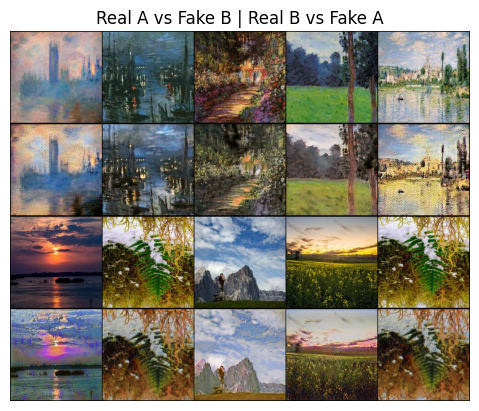

In [67]:
sample_images()

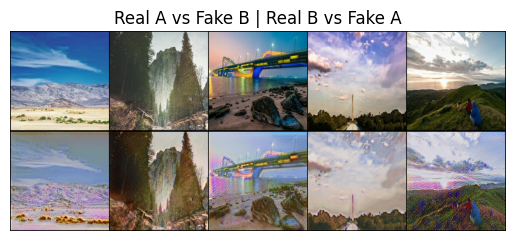

In [70]:
imgs = next(iter(val_dataloader))
G_AB.eval()
G_BA.eval()
real_A = imgs['A'].type(Tensor) # A : monet
fake_B = G_AB(real_A).detach()
real_B = imgs['B'].type(Tensor) # B : photo
fake_A = G_BA(real_B).detach()
# Arange images along x-axis
real_A = make_grid(real_A, nrow=5, normalize=True)
fake_B = make_grid(fake_B, nrow=5, normalize=True)
real_B = make_grid(real_B, nrow=5, normalize=True)
fake_A = make_grid(fake_A, nrow=5, normalize=True)
# Arange images along y-axis    
image_grid = torch.cat((real_B, fake_A), 1)
plt.imshow(image_grid.cpu().permute(1,2,0))
plt.title('Real A vs Fake B | Real B vs Fake A')
plt.axis('off')
plt.show();